# Exploring Determinators of SAT Scores

## Table of Contents
* Intro
 * [The Goal](#the_goal)
   * [Summary of Results](#summary_of_results)
 * [Background](#background)
 * [The Data](#the_data)
 * [Read in the data](#read_in_the_data)
* [Data Cleaning](#data_cleaning)
 * [Add DBN columns](#add_dbn_columns)
 * [Convert columns to numeric](#convert_columns_to_numeric)
 * [Condense datasets](#condense_datasets)
 * [Combine the datasets](#combine_the_datasets)
 * [Add a school district column for mapping](#add_a_school_dist)
* [Analysis](#analysis)
 * [Plotting survey correlations](#plotting_survey_corrs)
 * [Exploring Safety and SAT scores](#exploring_safety_and_sat_scores)
   * [Investigating correlation between SAT and safety scores](#sat_and_safety_corr)
   * [Computing Safety Scores by Borough](#safety_scores_by_borough)
 * [Exploring Race and SAT Scores](#exploring_race_and_sat_scores)
   * [Exploring low SAT scores and high hispanic %](#exploring_sat_scores_and_hisp_per)
   * [Exploring Schools with a high percentage of hispanic students](#exploring_schools_w_high_hisp_per)
   * [Exploring Schools with a low percentage of hispanic students](#exploring_schools_w_low_hisp_per)
 * [Exploring Gender and SAT Scores](#exploring_gender_and_sat_scores)
   * [Investigating Gender Differences in SAT Scores](#invest_gender_diff_in_sat_scores)
   * [Investigating Schools with High SAT Scores by Gender](#invest_schools_w_high_sat_scores_by_gender)
 * [Exploring AP Scores vs. SAT Scores](#exploring_ap_scores_vs_sat)
 * [Exploring Class Size vs. SAT Score](#exploring_class_size_vs_sat)
 * [Exploring Which School Districts have the highest SAT Scores](#exploring_school_dists_with_highest_sat_scores)

## The Goal <a name="the_goal"></a>
In this project we'll analyze various demographic data to see if we can find a clear relation between them and a school's average SAT score.

### Summary of Results <a name="summary_of_results"></a>
We found thyat these determinators have a weak link to the SAT scores:
* Safety
* Race makeup of the schools' students
* Gender
* AP Score
* Class size

## Background <a name="background"></a>
The SAT, or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. The SAT has three sections, each is worth 800 points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.
New York City has a significant immigrant population and is very diverse, so comparing demographic factors such as race, income, and gender with SAT scores is a good way to determine whether the SAT is a fair test. For example, if certain racial groups consistently perform better on the SAT, we would have some evidence that the SAT is unfair.

## The Data <a name="the_data"></a>
New York City has published data on student SAT scores by high school, along with additional demographic datasets. During some of the other lessons, we combined the following datasets into a single, clean pandas dataframe:

* [SAT scores by school](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) - SAT scores for each high school in New York City
* [School attendance](https://data.cityofnewyork.us/Education/School-Attendance-and-Enrollment-Statistics-by-Dis/7z8d-msnt) - Attendance information for each school in New York City
* [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school
* [AP test results](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
* [Graduation outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a) - The percentage of students who graduated and other outcome information
* [Demographics](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j) - Demographic information for each school
* [School survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) - Surveys of parents, teachers, and students at each school

## Read in the data <a name="read_in_the_data"></a>

In [1]:
import pandas as pd
import numpy
import re

# Allow us to create coloured handles for legends
import matplotlib.patches as mpatches

# Set up matplotlib to work in Jupytter notebook
import matplotlib.pyplot as plt
%matplotlib inline

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

In [2]:
# Reading in the surveys
# The surveys' format is slightly different, so we're reading them separately,
# then merging them and adding to the 'data' dataframe
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Data Cleaning <a name="data_cleaning"></a>

## Add DBN columns <a name="add_dbn_columns"></a>

A DBN is a school's unique identifier. It's composed of a CSD (District + Borough number) and a school code. 
Since our data is composed of several datasets we want to use the DBNs to identify each school across the datasets.

The Class Size survey has no DBN data, so we're generating it from the CSD and the school code data.

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

## Convert columns to numeric <a name="convert_columns_to_numeric"></a>

To allow us to better analyze the data we'll convert some textual numeric data to actual numeric type.

In [4]:
sat_results_cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in sat_results_cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][sat_results_cols[0]] + \
                                   data['sat_results'][sat_results_cols[1]] + \
                                   data['sat_results'][sat_results_cols[2]]

# Convert AP scores to numeric
ap_cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in ap_cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

# Split location data to latitude and longitude values
data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

## Condense datasets <a name="condense_datasets"></a>

Remove data that isn't relevant to our analysis.

In [5]:
# We only care about 9-12 graders for General Ed.
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## Combine the datasets <a name="combine_the_datasets"></a>

Now we're ready to combine all the datasets into a single dataset, using the DBN to merge them on. 

In [6]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

## Add a school district column for mapping <a name="add_a_school_dist"></a>

Extracting the school district data from the DBN, to allow analysis by district.

In [7]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Analysis <a name="analysis"></a>

## Plotting survey correlations <a name="plotting_survey_corrs"></a>

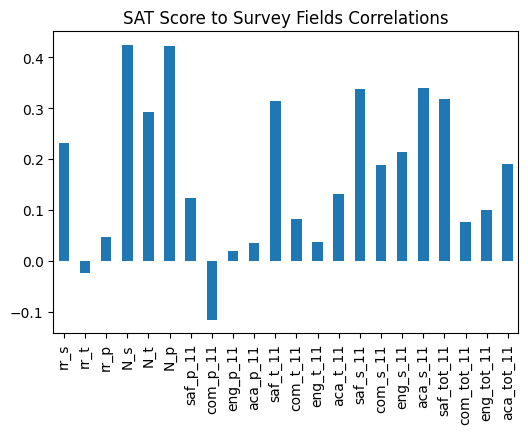

In [8]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

# Find correlations between the SAT score and all other columns
correlations = combined.corr()['sat_score']

# Plot a bar plot of the correlation between SAT Score and survey results
survey_correlations = correlations[survey_fields]
survey_correlations.plot.bar(title="SAT Score to Survey Fields Correlations")
plt.show()

In the graph we notice two significant correlations - `N_s` (Number of student responders) and `N_p` (Number of parent responders. 
Additional strong correlations can be found with `saf_s`, `saf_t` and `saf_tot` (safety scores based on students, teachers and total score, respectively), and also with `aca_s` (Academic expectations score, based on student responses).

Let's dig into the safety scores a bit more and see what we can learn from them.

## Exploring Safety and SAT scores <a name="exploring_safety_and_sat_scores"></a>

### Investigating correlation between SAT and safety scores <a name="sat_and_safety_corr"></a>

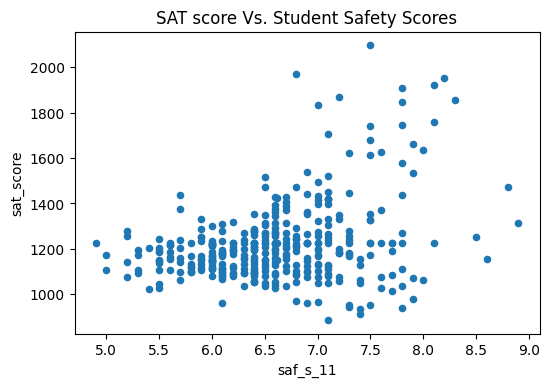

In [9]:
combined.plot.scatter(x="saf_s_11", y="sat_score", title="SAT score Vs. Student Safety Scores")
plt.show()

In the graph above we plotted the SAT score vs. saf_s_11, which measures how students perceive safety at school.
There seems to be a slight correlation between higher safety and SAT scores. Also, higher SAT scores are almost exclusively the domain of schools with a safety score of 7.0 and above.

### Computing Safety Scores by Borough <a name="safety_scores_by_borough"></a>

In [10]:
# Calculate the mean safety scores by borough, as given by students (saf_s_11) and teachers (saf_t_11)
combined.groupby('boro').agg('mean')[['saf_s_11', 'saf_t_11']]

,saf_s_11,saf_t_11
boro,,
Bronx,6.606577,7.026882
Brooklyn,6.370755,6.985849
Manhattan,6.831370,7.287778
Queens,6.721875,7.365625
Staten Island,6.530000,7.210000


The differences in safety scores as given by students between the New-York's five boroughs aren't significant. The range spans from 6.37 (Brooklyn) to 6.83 (Manhattan), a difference of 0.46 points.
The teachers, in general, tend to give higher scores, but here too the range is quite narrow, spanning from 6.99 (Brooklyn) to 7.37 (Queens) a difference of 0.38 points. So let's explore other data.

## Exploring Race and SAT Scores <a name="exploring_race_and_sat_scores"></a>

There are a few columns that indicate the percentage of each race at a given school:

* `white_per`
* `asian_per`
* `black_per`
* `hispanic_per`

By plotting out the correlations between these columns and `sat_score`, we can determine whether there are any racial differences in SAT performance.

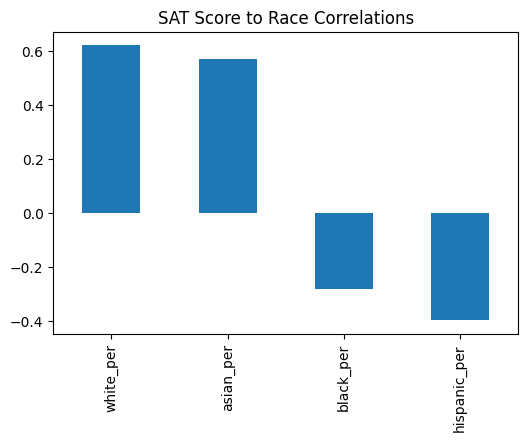

In [11]:
race_fields = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
# Plotting a bar plot of the correlation between SAT Score and race
race_correlations = correlations[race_fields]
race_correlations.plot.bar(title="SAT Score to Race Correlations")


From the graph we can clearly see that SAT scores correlate with high percentage of white and asian students, whereas a high percentage of hispanic students correlates negatively. The percentage of black students has a less significant correlation with SAT scores.
Let's look into that a bit more.

### Exploring low SAT scores and high hispanic % <a name="exploring_sat_scores_and_hisp_per"></a>

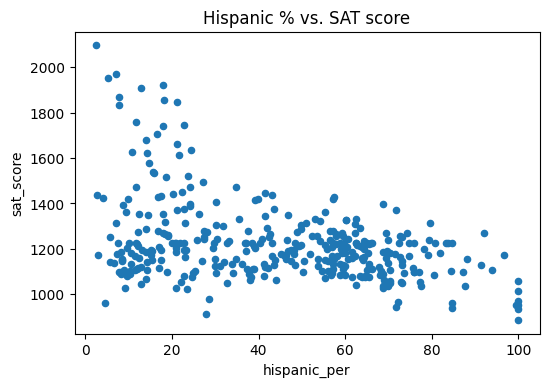

In [12]:
combined.plot.scatter(x="hispanic_per", y="sat_score", title="Hispanic % vs. SAT score")

From the graph we can see that for schools with less than about 30% of hispanic students, that doesn't correlate at all with SAT scores, but above that line the score doesn't reach above 1500, and there's a slight trend towards lower scores the more the percentage increases.

### Exploring Schools with a high percentage of hispanic students <a name="exploring_schools_w_high_hisp_per"></a>
Let's look at schools with a high percenrage of Hispanic students and a low SAT score, and see if we can learn something from them.

In [13]:
# Filtering combined to show only schools with >95% hispanic students
high_hispanic_per = combined[combined['hispanic_per'] > 95]
high_hispanic_per[['Name', 'hispanic_per', 'sat_score']]

,Name,hispanic_per,sat_score
44,MANHATTAN BRIDGES HIGH SCHOOL,99.8,1058.0
82,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,96.7,1174.0
89,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND MAT,99.8,1014.0
125,ACADEMY FOR LANGUAGE AND TECHNOLOGY,99.4,951.0
141,INTERNATIONAL SCHOOL OF LIBERAL ARTS,99.8,934.0
176,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,99.8,970.0
253,MULTICULTURAL HIGH SCHOOL,99.8,887.0
286,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,100.0,951.0


The above schools are moslty schools aimed at immigrant popoulation, for which English isn't their first language. These schools focus more on teaching English as a secondary language, and less on academic excellence, which can definitely explain the lower SAT scores.

### Exploring Schools with a low percentage of hispanic students <a name="exploring_schools_w_low_hisp_per"></a>

In [14]:
# Filtering combined to show only schools with <10% hispanic students
# and >1800 SAT score
high_hispanic_per = combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]
high_hispanic_per[['school_name', 'hispanic_per', 'sat_score']]

,school_name,hispanic_per,sat_score
37,Stuyvesant High School,2.4,2096.0
151,Bronx High School of Science,7.2,1969.0
187,Brooklyn Technical High School,7.9,1833.0
327,Queens High School for the Sciences at York Co...,7.9,1868.0
356,Staten Island Technical High School,5.3,1953.0


These schools are highly competitve, prestigious schools. They all have challenging admission tests, and offer a curriculum focused on academic excellence. These are all factors that contribute to a high SAT score average.

## Exploring Gender and SAT Scores <a name="exploring_gender_and_sat_scores"></a>

We can use our data to investigate correlations between a person's gender and their SAT score.


### Investigating Gender Differences in SAT Scores <a name="invest_gender_diff_in_sat_scores"></a>
There are two columns that indicate the percentage of each gender at a school:

* `male_per`
* `female_per`

We can plot out the correlations between each percentage and sat_score.

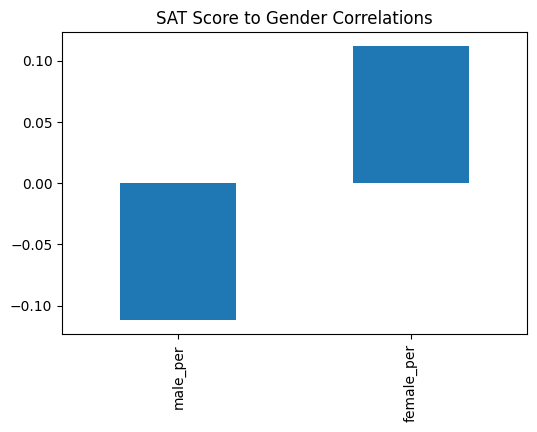

In [15]:
gender_fields = ['male_per', 'female_per']
# Plotting a bar plot of the correlation between SAT Score and gender
gender_correlations = correlations[gender_fields]
gender_correlations.plot.bar(title="SAT Score to Gender Correlations")

The graph shows a rather weak correlation between a person's gender and their SAT score, with a -0.1 correlation for males and 0.1 for females. This suggests that there are stronger factors that will determine a person's success in passing the SAT.

### Investigating Schools with High SAT Scores by Gender <a name="invest_schools_w_high_sat_scores_by_gender"></a>

Let's look at it from another angle - we can look at schools that have a high average SAT score and see if that correlates to a high percentage of students of a certain gender:

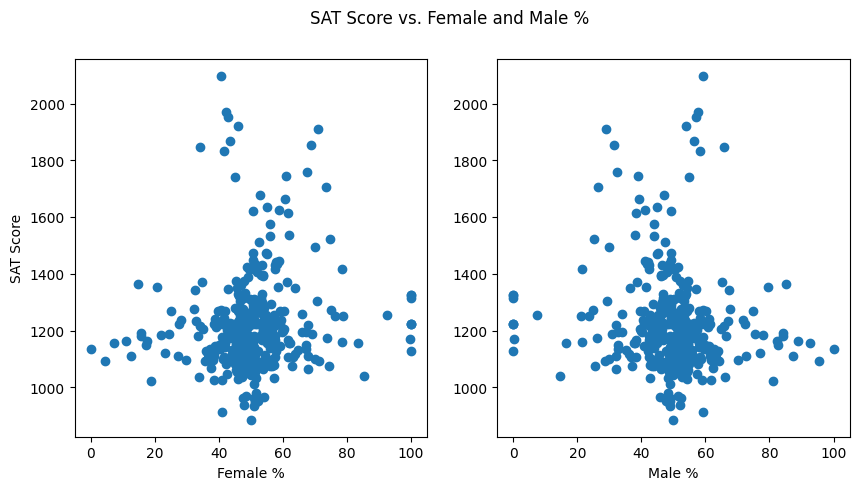

In [16]:
# Plot SAT Score Vs. female and male percentages

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('SAT Score vs. Female and Male %')
ax1.scatter(combined['female_per'], combined['sat_score'])
ax1.set_xlabel('Female %')
ax1.set_ylabel('SAT Score')
ax2.scatter(combined['male_per'], combined['sat_score'])
ax2.set_xlabel('Male %')
plt.show()

The graphs show an interesting pattern - it seems that the highest-performing schools, SAT-wise, are ones where the male/female ratios are slightly skewed towards one gender. Schools with around 70% females or 60% males tend to have a higher average SAT score.
Students from schools which are predominantly male/female generally don't do well on the SAT.

Let's investigate these schools:

In [17]:
# Listing all schools with a male/female percentage higher than 60% and an average SAT score > 1700
combined[((combined['female_per'] > 60) | (combined['male_per'] > 60)) & (combined['sat_score'] > 1700)][['school_name', 'male_per', 'female_per', 'sat_score']]

,school_name,male_per,female_per,sat_score
5,Bard High School Early College,31.3,68.7,1856.0
26,Eleanor Roosevelt High School,32.5,67.5,1758.0
60,Beacon High School,39.0,61.0,1744.0
61,Fiorello H. LaGuardia High School of Music & A...,26.4,73.6,1707.0
79,"High School for Mathematics, Science and Engin...",65.8,34.2,1847.0
302,Townsend Harris High School,28.9,71.1,1910.0


Much like the schools in the "Exploring Schools with a low percentage of hispanic students" section, these schools all have a high acceptance bar and are focused on academic excellence. There's one notable exception - The Fiorello H. LaGuardia High School - which is an institute that specializes in teaching music and art. The school doesn't have admission tests, but it does accept students only after passing an audition. Also, similarly to the other schools on the list, one of its missions is to prepare its students for higher education, which would translate to a higher average SAT score.

## Exploring AP Scores vs. SAT Scores <a name="exploring_ap_scores_vs_sat"></a>

In the U.S., high school students take [Advanced Placement](https://en.wikipedia.org/wiki/Advanced_Placement_exams) (AP) exams to earn college credit. There are AP exams for many different subjects.

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. Let's explore this relationship. Because `total_enrollment` is highly correlated with `sat_score`, we don't want to lead to bias results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.

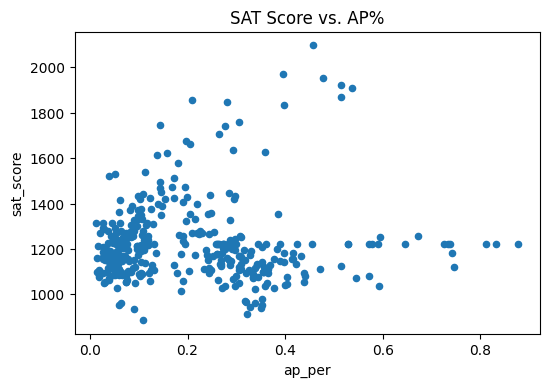

In [18]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

combined.plot.scatter('ap_per', 'sat_score', title="SAT Score vs. AP%")

Looking at the graph we can see that the AP takers are actually composed of two rather distinct populations - the first one correlates quite nicely with the SAT score, and the other doesn't show any correlation; its SAT score seems to cap at slightly above 1200, no matter what percentage took AP exams.

## Exploring Class Size vs. SAT Score <a name="exploring_class_size_vs_sat"></a>

It's considered a common knowledge that large classes usually tend to impact the academic achievements of their students for the worse. Let's see if that's reflected in our data

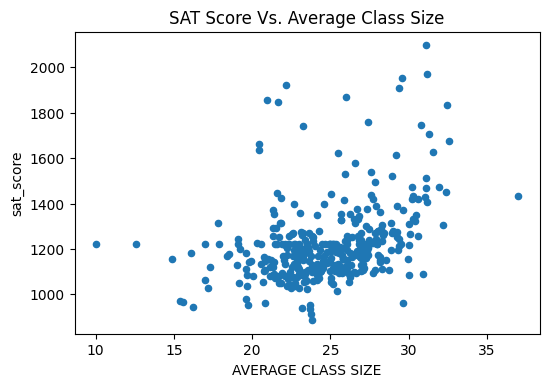

In [19]:
combined.plot.scatter('AVERAGE CLASS SIZE', 'sat_score', title="SAT Score Vs. Average Class Size")

In [20]:
corr = combined['AVERAGE CLASS SIZE'].corr(combined['sat_score'])
print(f"The Pearson correlation coefficient between SAT score and average class size: {corr:.2}")

The Pearson correlation coefficient between SAT score and average class size: 0.38


Quite unexpectedly, there seems to be a positive correlation between class size and SAT score, meaning that the larger the class, the higher the average SAT score tends to be. It's not a strong correlation - only 0.38, but it's significant. But before drawing any conclusions it's best to check if class size correlates with other factors, whith may be more significant in affecting the SAT score.

## Exploring Which School Districts have the highest SAT Scores <a name="exploring_school_dists_with_highest_sat_scores"></a>

We can use the data to show which districts have the highest-scoring schools, and which borough has the most high-scoring districts.

To do that, let's start by assigning a color for each of the five districts:

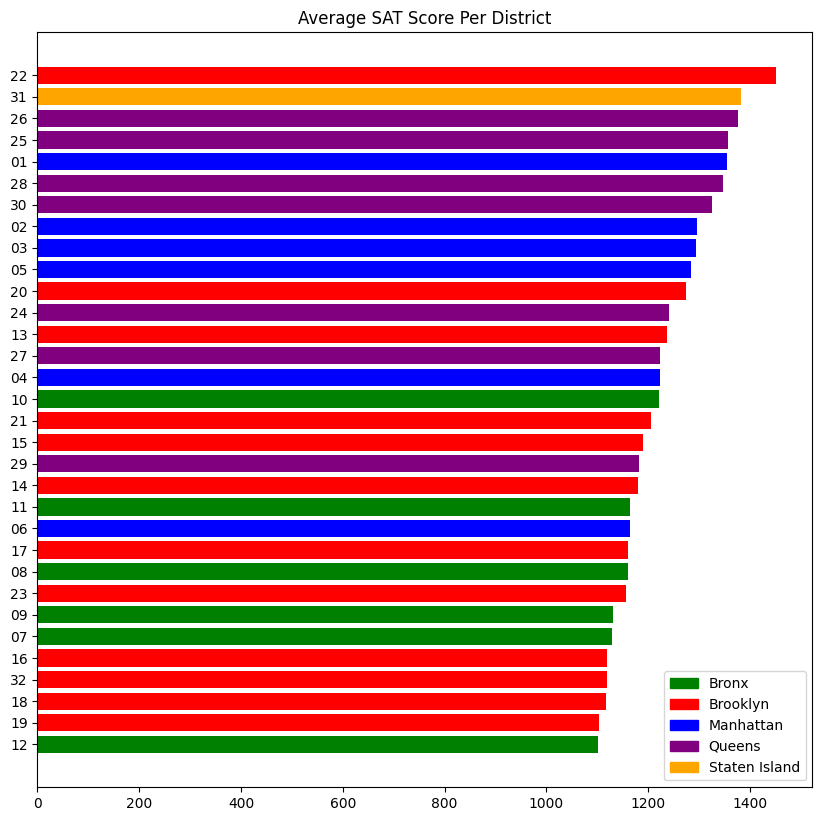

In [21]:
# Aggregating by borough and district.
school_dist_data_agg = combined.groupby(['school_dist', 'boro'], as_index = False) \
                               .agg({'sat_score': numpy.mean}) \
                               .sort_values(by = 'sat_score', ascending = True)

# Assigning a color for each of the five boroughs
boro_colors_dict = {'Bronx': 'green', 'Brooklyn': 'red', 'Manhattan': 'blue', 'Queens': 'purple', 'Staten Island': 'orange'}

# Using the colors to color each district
dist_colors = list(school_dist_data_agg['boro'].map(boro_colors_dict))

# Creating handles for the legend
handles = [mpatches.Patch(color=item[1], label=item[0]) for item in boro_colors_dict.items()]

#Visualising the data
plt.figure(figsize=(10,10))
plt.barh(school_dist_data_agg['school_dist'], school_dist_data_agg['sat_score'], color=dist_colors)
plt.title('Average SAT Score Per District')
plt.legend(handles=handles)
plt.show()

A few things we can learn from the above graph:

* Brooklyn has the top-scoring district, but the other districts in the borough tend to dominate the lower part of the graph, so in general it's not a high-performing borough
* Staten Island has only one school district, but it's a very high-scoring one, SAT-wise
* Both Queen and Manhattan have 4 districts in the top 10 highest-scoring districts, with Queens' districts generally placing higher than Manhattan's
* Generallyt, Queens' schools are the highest-scoring, with almost all of the borough's districts located in the top half of the chart
* In contrast, Bronx's districts are almost entirely in the bottom half of the chart, with its highest-scoring district reaching only the 16th place


## Conclusion <a name="conclusion"></a>

In this project we looked at various publicly available sources to try and determine factors that correlate with a high average SAT score in schools in NYC.
Since the factors determining a school's average SAT score are varied, we couldn't find a single factor that strongly correlated with a high average SAT score.

* Students from schools that are considered safe generally score higher in the SAT
* Schools with a higher population of white and/or Asian students tend to get higher SAT scores than ones with a higher black/Hispanic population. The reason these schools are underperforming is probably because their focus is on learning language, not academic excellence.
* Schools with an imbalanced gender divide (60-70% male or female students) tend to perform better in the SATs than schools that are more evenly split between the genders, or ones that are predominantly male/female
* Class size has a weak correlation with SAT scores, but what's surprising is that that correlation is positive
* Almost every borough has a district in the top-5 highest performing districts. Unless you're living in The Bronx you don't need to leave your borough in order to send your kids to a good school